In [1]:
# Librerias necesarias
import numpy as np
import numpy
from scipy import stats
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.morphology import remove_small_holes, erosion, square
import warnings
import math
warnings.filterwarnings("ignore")
from numpy import linalg as LA
import cv2

In [2]:
def sacar_imagen_canal(imagen, canal):
    matriz = []
    for i in range(len(imagen)):
        fila = []
        for j in range(len(imagen[0])):
            fila.append(np.uint8(imagen[i][j][canal]))
        fila = np.array(fila)
        matriz.append(fila)
    matriz = np.array(matriz)
    return matriz

In [3]:
def transformacion_imagen(imagen, ruido):
    nueva_imagen = []
    for i in range(len(imagen)):
        lista = []
        for j in range(len(imagen[0])):
            R = max(min(int(imagen[i][j][0] + ruido[i][j][0]),255), 0)
            G = max(min(int(imagen[i][j][1] + ruido[i][j][1]),255), 0)
            B = max(min(int(imagen[i][j][2] + ruido[i][j][2]),255), 0)
            lista.append([R,G,B])
        nueva_imagen.append(lista)
    return nueva_imagen

In [4]:
def maxima_intensidad_imagen(imagen):
    lista = []
    for i in range(len(imagen)):
        for j in range(len(imagen[0])):
            lista.append(imagen[i][j][0])
            lista.append(imagen[i][j][1])
            lista.append(imagen[i][j][2])
    maximo = max(lista)
    return maximo

In [5]:
def muestreo_normal(porcentaje, imagen):
    maxima_intensidad = maxima_intensidad_imagen(imagen)
    sigma = porcentaje*maxima_intensidad
    
    total_datos = len(imagen)*len(imagen[0])
    
    muestreo_1 = np.random.normal(0, sigma, total_datos)
    muestreo_2 = np.random.normal(0, sigma, total_datos)
    muestreo_3 = np.random.normal(0, sigma, total_datos)
    
    ruido = []
    
    alto = len(imagen)
    ancho = len(imagen[0])
    
    for i in range(alto):
        lista = []
        for j in range(ancho):
            lista.append([muestreo_1[j + i*ancho], muestreo_2[j + i*ancho], muestreo_3[j + i*ancho]])
        ruido.append(lista)
    
    return ruido

In [6]:
def union_imagen(imagen_1, imagen_2, imagen_3):
    matriz = []
    for i in range(len(imagen_1)):
        fila = []
        for j in range(len(imagen_1[0])):
            fila.append([imagen_1[i][j], imagen_2[i][j], imagen_3[i][j]])
        matriz.append(fila)
    return matriz

In [7]:
def imagen_circulo_borde(imagen, radio):
    M = len(imagen)
    N = len(imagen[0])
    C_1 = int(M/2)
    C_2 = int(N/2)
    matriz = []
    for i in range(M):
        fila = []
        for j in range(N):
            fila.append(0)
        matriz.append(fila)
    for k in range(C_1-radio, C_1 + radio + 1):
        altura_1 = int(C_2 + math.sqrt(radio**2-(k - C_1)**2))
        altura_2 = int(C_2 - math.sqrt(radio**2-(k - C_1)**2))
        matriz[k][altura_1] = 1
        matriz[k][altura_2] = 1
    return matriz

In [8]:
def filtro_pasa_alto(imagen, radio):
    matriz_nueva = imagen_circulo_borde(imagen, radio)
    for i in range(len(matriz_nueva)):
        valores_uno = []
        for j in range(len(matriz_nueva[0])):
            if matriz_nueva[i][j] == 1:
                valores_uno.append(j)
        if len(valores_uno) > 1:
            minimo = min(valores_uno)
            maximo = max(valores_uno)
            for k in range(minimo, maximo + 1):
                matriz_nueva[i][k] = 1
    return matriz_nueva

In [9]:
def aplicar_filtro_pasa_alto(imagen_frecuencia, radio):
    matriz = filtro_pasa_alto(imagen_frecuencia, radio)
    matriz_nueva = []
    for i in range(len(imagen_frecuencia)):
        fila = []
        for j in range(len(imagen_frecuencia[0])):
            if matriz[i][j] == 1:
                fila.append(np.complex(0))
            else:
                fila.append(imagen_frecuencia[i][j])
        fila = np.array(fila)
        matriz_nueva.append(fila)
    matriz_nueva = np.array(matriz_nueva)
    return matriz_nueva

In [10]:
def aplicar_filtro_pasa_bajo(imagen_frecuencia, radio):
    matriz = filtro_pasa_alto(imagen_frecuencia, radio)
    matriz_nueva = []
    for i in range(len(imagen_frecuencia)):
        fila = []
        for j in range(len(imagen_frecuencia[0])):
            if matriz[i][j] == 1:
                fila.append(imagen_frecuencia[i][j])
            else:
                fila.append(np.complex(0))
        fila = np.array(fila)
        matriz_nueva.append(fila)
    matriz_nueva = np.array(matriz_nueva)
    return matriz_nueva

In [11]:
def aplicar_filtro_pasa_bajo_alto(imagen_frecuencia, radio_1, radio_2):
    retorno_1 = aplicar_filtro_pasa_bajo(imagen_frecuencia, radio_2)
    retorno_2 = aplicar_filtro_pasa_alto(retorno_1, radio_1)
    return retorno_2

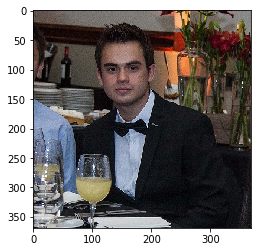

In [12]:
# Cargar Imagen:Beto

beto = plt.imread('beto.jpg')
plt.imshow(beto)

In [13]:
#Creacion de imagen con ruido 1

porcentaje_1 = 0.05
ruido_1 = muestreo_normal(porcentaje_1, beto)
nueva_imagen_1_beto = transformacion_imagen(beto, ruido_1)

In [14]:
#Creacion de imagen con ruido 2

porcentaje_2 = 0.03
ruido_2 = muestreo_normal(porcentaje_2, beto)
nueva_imagen_2_beto = transformacion_imagen(beto, ruido_2)

In [15]:
#Creacion de imagen con ruido 3

porcentaje_3 = 0.01
ruido_3 = muestreo_normal(porcentaje_3, beto)
nueva_imagen_3_beto = transformacion_imagen(beto, ruido_3)

In [16]:
#Calcular las transformadas de fourier de cada canal para la imagen con ruido 1

nueva_imagen_1_beto_rojo = sacar_imagen_canal(nueva_imagen_1_beto, 0)
nueva_imagen_1_beto_verde = sacar_imagen_canal(nueva_imagen_1_beto, 1)
nueva_imagen_1_beto_azul = sacar_imagen_canal(nueva_imagen_1_beto, 2)

f_rojo_1 = np.fft.fft2(nueva_imagen_1_beto_rojo)
f_verde_1 = np.fft.fft2(nueva_imagen_1_beto_verde)
f_azul_1 = np.fft.fft2(nueva_imagen_1_beto_azul)

fshift_rojo_1 = np.fft.fftshift(f_rojo_1)
fshift_verde_1 = np.fft.fftshift(f_verde_1)
fshift_azul_1 = np.fft.fftshift(f_azul_1)

magnitud_espectro_rojo_1 = 20*np.log(np.abs(fshift_rojo_1))
magnitud_espectro_verde_1 = 20*np.log(np.abs(fshift_verde_1))
magnitud_espectro_azul_1 = 20*np.log(np.abs(fshift_azul_1))

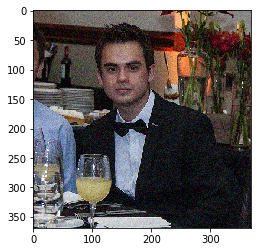

In [17]:
plt.imshow(nueva_imagen_1_beto)

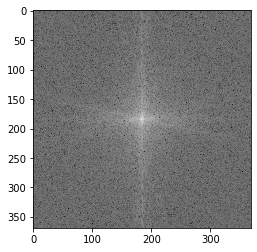

In [18]:
plt.imshow(magnitud_espectro_rojo_1, cmap = 'gray')

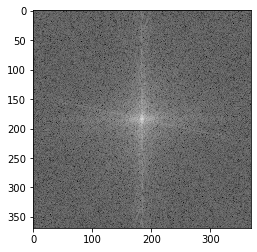

In [19]:
plt.imshow(magnitud_espectro_verde_1, cmap = 'gray')

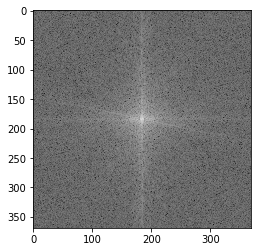

In [20]:
plt.imshow(magnitud_espectro_azul_1, cmap = 'gray')

In [21]:
#Calcular las transformadas de fourier de cada canal para la imagen con ruido 2

nueva_imagen_2_beto_rojo = sacar_imagen_canal(nueva_imagen_2_beto, 0)
nueva_imagen_2_beto_verde = sacar_imagen_canal(nueva_imagen_2_beto, 1)
nueva_imagen_2_beto_azul = sacar_imagen_canal(nueva_imagen_2_beto, 2)

f_rojo_2 = np.fft.fft2(nueva_imagen_2_beto_rojo)
f_verde_2 = np.fft.fft2(nueva_imagen_2_beto_verde)
f_azul_2 = np.fft.fft2(nueva_imagen_2_beto_azul)

fshift_rojo_2 = np.fft.fftshift(f_rojo_2)
fshift_verde_2 = np.fft.fftshift(f_verde_2)
fshift_azul_2 = np.fft.fftshift(f_azul_2)

magnitud_espectro_rojo_2 = 20*np.log(np.abs(fshift_rojo_2))
magnitud_espectro_verde_2 = 20*np.log(np.abs(fshift_verde_2))
magnitud_espectro_azul_2 = 20*np.log(np.abs(fshift_azul_2))

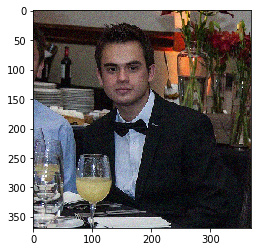

In [22]:
plt.imshow(nueva_imagen_2_beto)

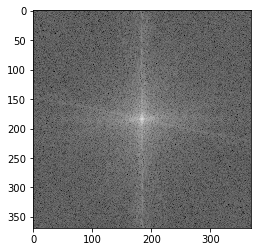

In [23]:
plt.imshow(magnitud_espectro_rojo_2, cmap = 'gray')

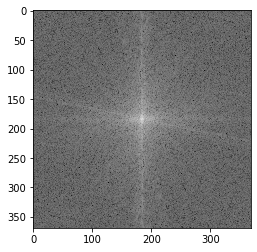

In [24]:
plt.imshow(magnitud_espectro_verde_2, cmap = 'gray')

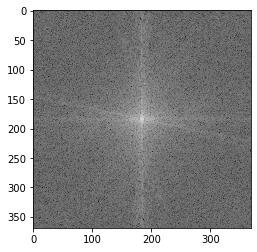

In [25]:
plt.imshow(magnitud_espectro_azul_2, cmap = 'gray')

In [26]:
#Calcular las transformadas de fourier de cada canal para la imagen con ruido 3

nueva_imagen_3_beto_rojo = sacar_imagen_canal(nueva_imagen_3_beto, 0)
nueva_imagen_3_beto_verde = sacar_imagen_canal(nueva_imagen_3_beto, 1)
nueva_imagen_3_beto_azul = sacar_imagen_canal(nueva_imagen_3_beto, 2)

f_rojo_3 = np.fft.fft2(nueva_imagen_3_beto_rojo)
f_verde_3 = np.fft.fft2(nueva_imagen_3_beto_verde)
f_azul_3 = np.fft.fft2(nueva_imagen_3_beto_azul)

fshift_rojo_3 = np.fft.fftshift(f_rojo_3)
fshift_verde_3 = np.fft.fftshift(f_verde_3)
fshift_azul_3 = np.fft.fftshift(f_azul_3)

magnitud_espectro_rojo_3 = 20*np.log(np.abs(fshift_rojo_3))
magnitud_espectro_verde_3 = 20*np.log(np.abs(fshift_verde_3))
magnitud_espectro_azul_3 = 20*np.log(np.abs(fshift_azul_3))

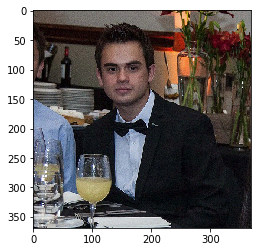

In [27]:
plt.imshow(nueva_imagen_3_beto)

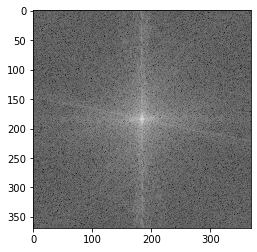

In [28]:
plt.imshow(magnitud_espectro_rojo_3, cmap = 'gray')

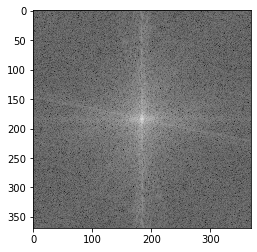

In [29]:
plt.imshow(magnitud_espectro_verde_3, cmap = 'gray')

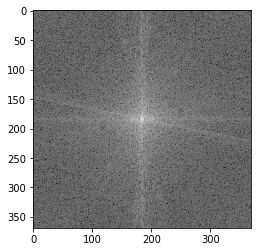

In [30]:
plt.imshow(magnitud_espectro_azul_3, cmap = 'gray')

$Filtro \ para \ eliminar \ ruido$

Este es un filtro pasa bajo el cual consiste en solo mantener los datos dentro de un circulo centrado en la imagen

In [31]:
radio = 100
fshift_rojo_1_modificado = aplicar_filtro_pasa_bajo(fshift_rojo_1, radio)
fshift_verde_1_modificado = aplicar_filtro_pasa_bajo(fshift_verde_1, radio)
fshift_azul_1_modificado = aplicar_filtro_pasa_bajo(fshift_azul_1, radio)

magnitud_espectro_rojo_1_modificado = 20*np.log(np.abs(fshift_rojo_1_modificado))
magnitud_espectro_verde_1_modificado = 20*np.log(np.abs(fshift_verde_1_modificado))
magnitud_espectro_azul_1_modificado = 20*np.log(np.abs(fshift_azul_1_modificado))

In [32]:
f_ishift_rojo_1_modificado = np.fft.ifftshift(fshift_rojo_1_modificado)
img_back_rojo_1_modificado = np.fft.ifft2(f_ishift_rojo_1_modificado)
img_back_rojo_1_modificado = np.uint8(np.abs(img_back_rojo_1_modificado))

f_ishift_verde_1_modificado = np.fft.ifftshift(fshift_verde_1_modificado)
img_back_verde_1_modificado = np.fft.ifft2(f_ishift_verde_1_modificado)
img_back_verde_1_modificado = np.uint8(np.abs(img_back_verde_1_modificado))

f_ishift_azul_1_modificado = np.fft.ifftshift(fshift_azul_1_modificado)
img_back_azul_1_modificado = np.fft.ifft2(f_ishift_azul_1_modificado)
img_back_azul_1_modificado = np.uint8(np.abs(img_back_azul_1_modificado))

imagen_total_1_modificado = union_imagen(img_back_rojo_1_modificado, img_back_verde_1_modificado, img_back_azul_1_modificado)

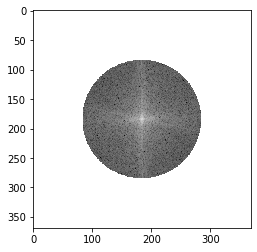

In [33]:
plt.imshow(magnitud_espectro_rojo_1_modificado, cmap = 'gray')

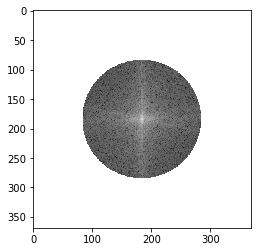

In [34]:
plt.imshow(magnitud_espectro_verde_1_modificado, cmap = 'gray')

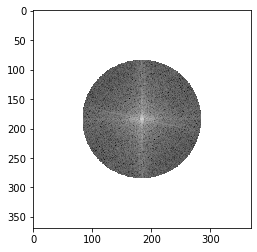

In [35]:
plt.imshow(magnitud_espectro_azul_1_modificado, cmap = 'gray')

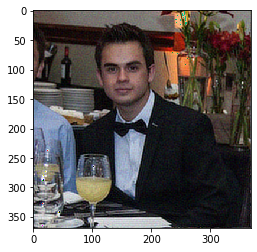

In [36]:
plt.imshow(imagen_total_1_modificado)

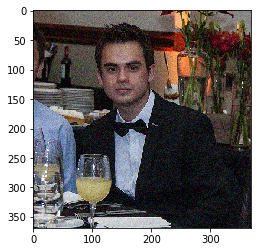

In [37]:
# Recordando la imagen con ruido
plt.imshow(nueva_imagen_1_beto)

In [38]:
radio = 100
fshift_rojo_2_modificado = aplicar_filtro_pasa_bajo(fshift_rojo_2, radio)
fshift_verde_2_modificado = aplicar_filtro_pasa_bajo(fshift_verde_2, radio)
fshift_azul_2_modificado = aplicar_filtro_pasa_bajo(fshift_azul_2, radio)

magnitud_espectro_rojo_2_modificado = 20*np.log(np.abs(fshift_rojo_2_modificado))
magnitud_espectro_verde_2_modificado = 20*np.log(np.abs(fshift_verde_2_modificado))
magnitud_espectro_azul_2_modificado = 20*np.log(np.abs(fshift_azul_2_modificado))

In [39]:
f_ishift_rojo_2_modificado = np.fft.ifftshift(fshift_rojo_2_modificado)
img_back_rojo_2_modificado = np.fft.ifft2(f_ishift_rojo_2_modificado)
img_back_rojo_2_modificado = np.uint8(np.abs(img_back_rojo_2_modificado))

f_ishift_verde_2_modificado = np.fft.ifftshift(fshift_verde_2_modificado)
img_back_verde_2_modificado = np.fft.ifft2(f_ishift_verde_2_modificado)
img_back_verde_2_modificado = np.uint8(np.abs(img_back_verde_2_modificado))

f_ishift_azul_2_modificado = np.fft.ifftshift(fshift_azul_2_modificado)
img_back_azul_2_modificado = np.fft.ifft2(f_ishift_azul_2_modificado)
img_back_azul_2_modificado = np.uint8(np.abs(img_back_azul_2_modificado))

imagen_total_2_modificado = union_imagen(img_back_rojo_2_modificado, img_back_verde_2_modificado, img_back_azul_2_modificado)

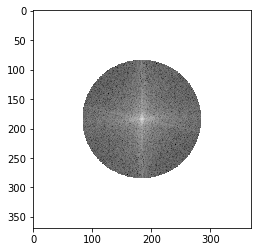

In [40]:
plt.imshow(magnitud_espectro_rojo_2_modificado, cmap = 'gray')

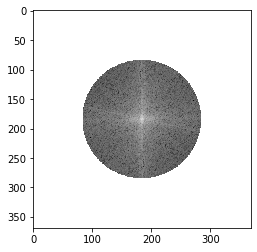

In [41]:
plt.imshow(magnitud_espectro_verde_2_modificado, cmap = 'gray')

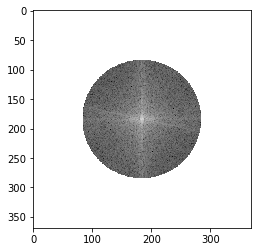

In [42]:
plt.imshow(magnitud_espectro_azul_2_modificado, cmap = 'gray')

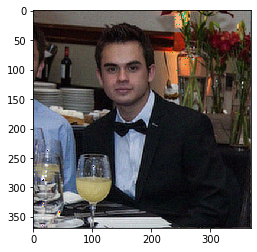

In [43]:
plt.imshow(imagen_total_2_modificado)

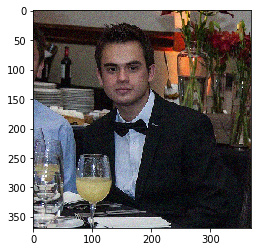

In [44]:
# Recordando la imagen con ruido
plt.imshow(nueva_imagen_2_beto)

In [45]:
radio = 100
fshift_rojo_3_modificado = aplicar_filtro_pasa_bajo(fshift_rojo_3, radio)
fshift_verde_3_modificado = aplicar_filtro_pasa_bajo(fshift_verde_3, radio)
fshift_azul_3_modificado = aplicar_filtro_pasa_bajo(fshift_azul_3, radio)

magnitud_espectro_rojo_3_modificado = 20*np.log(np.abs(fshift_rojo_3_modificado))
magnitud_espectro_verde_3_modificado = 20*np.log(np.abs(fshift_verde_3_modificado))
magnitud_espectro_azul_3_modificado = 20*np.log(np.abs(fshift_azul_3_modificado))

In [46]:
f_ishift_rojo_3_modificado = np.fft.ifftshift(fshift_rojo_3_modificado)
img_back_rojo_3_modificado = np.fft.ifft2(f_ishift_rojo_3_modificado)
img_back_rojo_3_modificado = np.uint8(np.abs(img_back_rojo_3_modificado))

f_ishift_verde_3_modificado = np.fft.ifftshift(fshift_verde_3_modificado)
img_back_verde_3_modificado = np.fft.ifft2(f_ishift_verde_3_modificado)
img_back_verde_3_modificado = np.uint8(np.abs(img_back_verde_3_modificado))

f_ishift_azul_3_modificado = np.fft.ifftshift(fshift_azul_3_modificado)
img_back_azul_3_modificado = np.fft.ifft2(f_ishift_azul_3_modificado)
img_back_azul_3_modificado = np.uint8(np.abs(img_back_azul_3_modificado))

imagen_total_3_modificado = union_imagen(img_back_rojo_3_modificado, img_back_verde_3_modificado, img_back_azul_3_modificado)

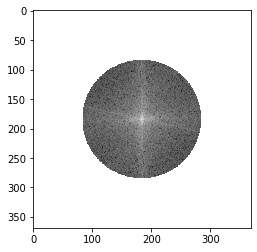

In [47]:
plt.imshow(magnitud_espectro_rojo_3_modificado, cmap = 'gray')

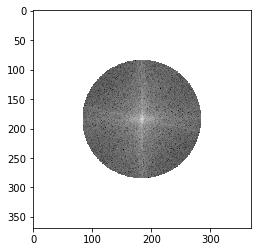

In [48]:
plt.imshow(magnitud_espectro_verde_3_modificado, cmap = 'gray')

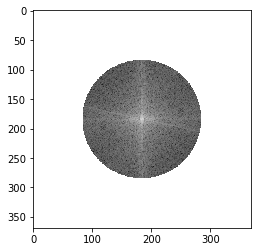

In [49]:
plt.imshow(magnitud_espectro_azul_3_modificado, cmap = 'gray')

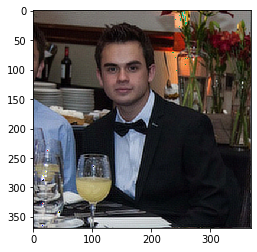

In [50]:
plt.imshow(imagen_total_3_modificado)

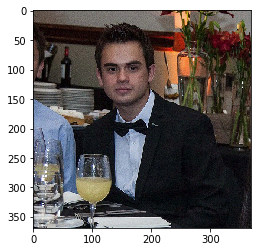

In [51]:
# Recordando la imagen con ruido
plt.imshow(nueva_imagen_3_beto)

$ Eliminar \ ruido \ y \ contrastar \ más \ los \ bordes $

Aquí se utiliza un filtro pasa alto y un filtro pasa bajo simultaneamente con estructura de circulo. Este tipo de filtros también se les conoce como "filtro pasa banda"

In [52]:
radio_2 = 100
radio_1 = 20
fshift_rojo_1_modificado = aplicar_filtro_pasa_bajo_alto(fshift_rojo_1, radio_1, radio_2)
fshift_verde_1_modificado = aplicar_filtro_pasa_bajo_alto(fshift_verde_1, radio_1, radio_2)
fshift_azul_1_modificado = aplicar_filtro_pasa_bajo_alto(fshift_azul_1, radio_1, radio_2)

magnitud_espectro_rojo_1_modificado = 20*np.log(np.abs(fshift_rojo_1_modificado))
magnitud_espectro_verde_1_modificado = 20*np.log(np.abs(fshift_verde_1_modificado))
magnitud_espectro_azul_1_modificado = 20*np.log(np.abs(fshift_azul_1_modificado))

In [53]:
f_ishift_rojo_1_modificado = np.fft.ifftshift(fshift_rojo_1_modificado)
img_back_rojo_1_modificado = np.fft.ifft2(f_ishift_rojo_1_modificado)
img_back_rojo_1_modificado = np.uint8(np.abs(img_back_rojo_1_modificado))

f_ishift_verde_1_modificado = np.fft.ifftshift(fshift_verde_1_modificado)
img_back_verde_1_modificado = np.fft.ifft2(f_ishift_verde_1_modificado)
img_back_verde_1_modificado = np.uint8(np.abs(img_back_verde_1_modificado))

f_ishift_azul_1_modificado = np.fft.ifftshift(fshift_azul_1_modificado)
img_back_azul_1_modificado = np.fft.ifft2(f_ishift_azul_1_modificado)
img_back_azul_1_modificado = np.uint8(np.abs(img_back_azul_1_modificado))

imagen_total_1_modificado = union_imagen(img_back_rojo_1_modificado, img_back_verde_1_modificado, img_back_azul_1_modificado)

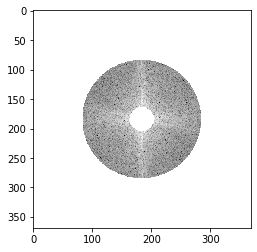

In [54]:
plt.imshow(magnitud_espectro_rojo_1_modificado, cmap = 'gray')

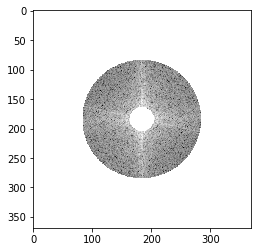

In [55]:
plt.imshow(magnitud_espectro_verde_1_modificado, cmap = 'gray')

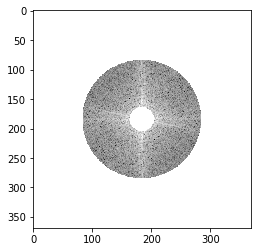

In [56]:
plt.imshow(magnitud_espectro_azul_1_modificado, cmap = 'gray')

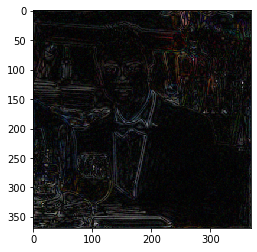

In [57]:
plt.imshow(imagen_total_1_modificado)

In [58]:
radio_2 = 100
radio_1 = 20
fshift_rojo_2_modificado = aplicar_filtro_pasa_bajo_alto(fshift_rojo_2, radio_1, radio_2)
fshift_verde_2_modificado = aplicar_filtro_pasa_bajo_alto(fshift_verde_2, radio_1, radio_2)
fshift_azul_2_modificado = aplicar_filtro_pasa_bajo_alto(fshift_azul_2, radio_1, radio_2)

magnitud_espectro_rojo_2_modificado = 20*np.log(np.abs(fshift_rojo_2_modificado))
magnitud_espectro_verde_2_modificado = 20*np.log(np.abs(fshift_verde_2_modificado))
magnitud_espectro_azul_2_modificado = 20*np.log(np.abs(fshift_azul_2_modificado))

In [59]:
f_ishift_rojo_2_modificado = np.fft.ifftshift(fshift_rojo_2_modificado)
img_back_rojo_2_modificado = np.fft.ifft2(f_ishift_rojo_2_modificado)
img_back_rojo_2_modificado = np.uint8(np.abs(img_back_rojo_2_modificado))

f_ishift_verde_2_modificado = np.fft.ifftshift(fshift_verde_2_modificado)
img_back_verde_2_modificado = np.fft.ifft2(f_ishift_verde_2_modificado)
img_back_verde_2_modificado = np.uint8(np.abs(img_back_verde_2_modificado))

f_ishift_azul_2_modificado = np.fft.ifftshift(fshift_azul_2_modificado)
img_back_azul_2_modificado = np.fft.ifft2(f_ishift_azul_2_modificado)
img_back_azul_2_modificado = np.uint8(np.abs(img_back_azul_2_modificado))

imagen_total_2_modificado = union_imagen(img_back_rojo_2_modificado, img_back_verde_2_modificado, img_back_azul_2_modificado)

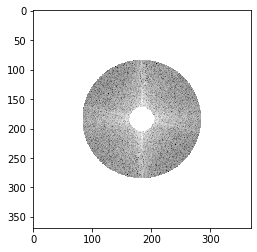

In [60]:
plt.imshow(magnitud_espectro_rojo_2_modificado, cmap = 'gray')

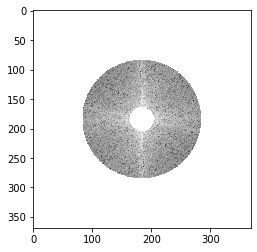

In [61]:
plt.imshow(magnitud_espectro_verde_2_modificado, cmap = 'gray')

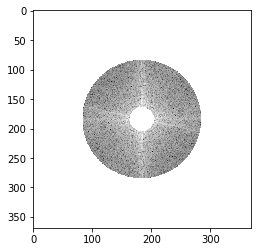

In [62]:
plt.imshow(magnitud_espectro_azul_2_modificado, cmap = 'gray')

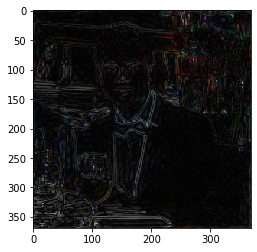

In [63]:
plt.imshow(imagen_total_2_modificado)

In [64]:
radio_2 = 100
radio_1 = 20
fshift_rojo_3_modificado = aplicar_filtro_pasa_bajo_alto(fshift_rojo_3, radio_1, radio_2)
fshift_verde_3_modificado = aplicar_filtro_pasa_bajo_alto(fshift_verde_3, radio_1, radio_2)
fshift_azul_3_modificado = aplicar_filtro_pasa_bajo_alto(fshift_azul_3, radio_1, radio_2)

magnitud_espectro_rojo_3_modificado = 20*np.log(np.abs(fshift_rojo_3_modificado))
magnitud_espectro_verde_3_modificado = 20*np.log(np.abs(fshift_verde_3_modificado))
magnitud_espectro_azul_3_modificado = 20*np.log(np.abs(fshift_azul_3_modificado))

In [65]:
f_ishift_rojo_3_modificado = np.fft.ifftshift(fshift_rojo_3_modificado)
img_back_rojo_3_modificado = np.fft.ifft2(f_ishift_rojo_3_modificado)
img_back_rojo_3_modificado = np.uint8(np.abs(img_back_rojo_3_modificado))

f_ishift_verde_3_modificado = np.fft.ifftshift(fshift_verde_3_modificado)
img_back_verde_3_modificado = np.fft.ifft2(f_ishift_verde_3_modificado)
img_back_verde_3_modificado = np.uint8(np.abs(img_back_verde_3_modificado))

f_ishift_azul_3_modificado = np.fft.ifftshift(fshift_azul_3_modificado)
img_back_azul_3_modificado = np.fft.ifft2(f_ishift_azul_3_modificado)
img_back_azul_3_modificado = np.uint8(np.abs(img_back_azul_3_modificado))

imagen_total_3_modificado = union_imagen(img_back_rojo_3_modificado, img_back_verde_3_modificado, img_back_azul_3_modificado)

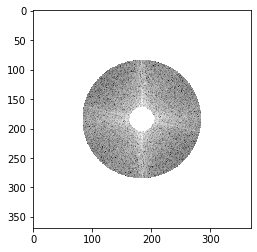

In [66]:
plt.imshow(magnitud_espectro_rojo_3_modificado, cmap = 'gray')

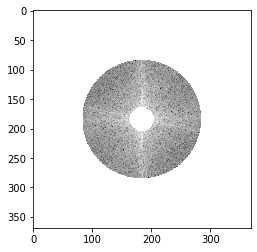

In [67]:
plt.imshow(magnitud_espectro_verde_3_modificado, cmap = 'gray')

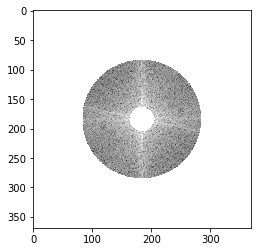

In [68]:
plt.imshow(magnitud_espectro_azul_3_modificado, cmap = 'gray')

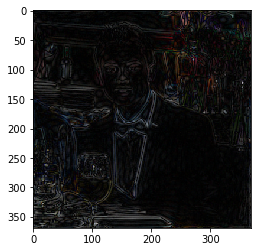

In [69]:
plt.imshow(imagen_total_3_modificado)

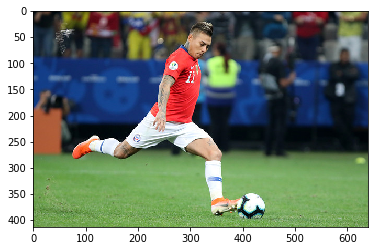

In [70]:
# Cargar Imagen:Vargas

vargas = plt.imread('vargas.jpg')
plt.imshow(vargas)

In [71]:
#Creacion de imagen con ruido 1

porcentaje_1 = 0.05
ruido_1 = muestreo_normal(porcentaje_1, vargas)
nueva_imagen_1_vargas = transformacion_imagen(vargas, ruido_1)

In [72]:
#Creacion de imagen con ruido 2

porcentaje_2 = 0.03
ruido_2 = muestreo_normal(porcentaje_2, vargas)
nueva_imagen_2_vargas = transformacion_imagen(vargas, ruido_2)

In [73]:
#Creacion de imagen con ruido 3

porcentaje_3 = 0.01
ruido_3 = muestreo_normal(porcentaje_3, vargas)
nueva_imagen_3_vargas = transformacion_imagen(vargas, ruido_3)

In [74]:
#Calcular las transformadas de fourier de cada canal para la imagen con ruido 1

nueva_imagen_1_vargas_rojo = sacar_imagen_canal(nueva_imagen_1_vargas, 0)
nueva_imagen_1_vargas_verde = sacar_imagen_canal(nueva_imagen_1_vargas, 1)
nueva_imagen_1_vargas_azul = sacar_imagen_canal(nueva_imagen_1_vargas, 2)

f_rojo_1 = np.fft.fft2(nueva_imagen_1_vargas_rojo)
f_verde_1 = np.fft.fft2(nueva_imagen_1_vargas_verde)
f_azul_1 = np.fft.fft2(nueva_imagen_1_vargas_azul)

fshift_rojo_1 = np.fft.fftshift(f_rojo_1)
fshift_verde_1 = np.fft.fftshift(f_verde_1)
fshift_azul_1 = np.fft.fftshift(f_azul_1)

magnitud_espectro_rojo_1 = 20*np.log(np.abs(fshift_rojo_1))
magnitud_espectro_verde_1 = 20*np.log(np.abs(fshift_verde_1))
magnitud_espectro_azul_1 = 20*np.log(np.abs(fshift_azul_1))

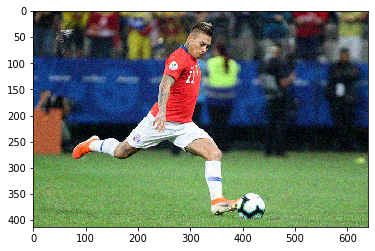

In [75]:
plt.imshow(nueva_imagen_1_vargas)

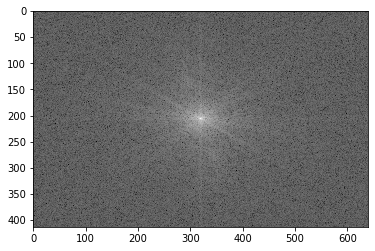

In [76]:
plt.imshow(magnitud_espectro_rojo_1, cmap = 'gray')

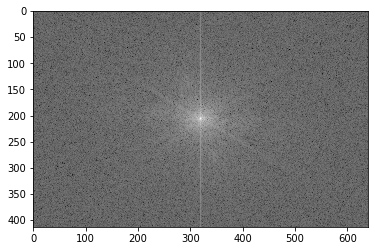

In [77]:
plt.imshow(magnitud_espectro_verde_1, cmap = 'gray')

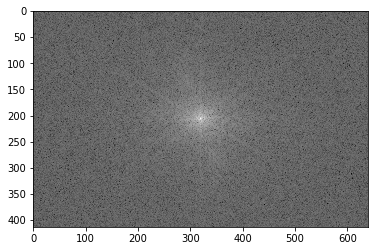

In [78]:
plt.imshow(magnitud_espectro_azul_1, cmap = 'gray')

In [79]:
#Calcular las transformadas de fourier de cada canal para la imagen con ruido 2

nueva_imagen_2_vargas_rojo = sacar_imagen_canal(nueva_imagen_2_vargas, 0)
nueva_imagen_2_vargas_verde = sacar_imagen_canal(nueva_imagen_2_vargas, 1)
nueva_imagen_2_vargas_azul = sacar_imagen_canal(nueva_imagen_2_vargas, 2)

f_rojo_2 = np.fft.fft2(nueva_imagen_2_vargas_rojo)
f_verde_2 = np.fft.fft2(nueva_imagen_2_vargas_verde)
f_azul_2 = np.fft.fft2(nueva_imagen_2_vargas_azul)

fshift_rojo_2 = np.fft.fftshift(f_rojo_2)
fshift_verde_2 = np.fft.fftshift(f_verde_2)
fshift_azul_2 = np.fft.fftshift(f_azul_2)

magnitud_espectro_rojo_2 = 20*np.log(np.abs(fshift_rojo_2))
magnitud_espectro_verde_2 = 20*np.log(np.abs(fshift_verde_2))
magnitud_espectro_azul_2 = 20*np.log(np.abs(fshift_azul_2))

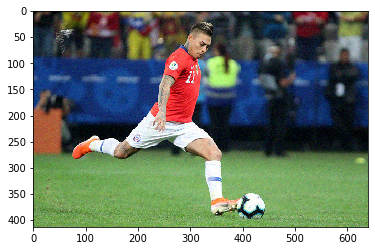

In [80]:
plt.imshow(nueva_imagen_2_vargas)

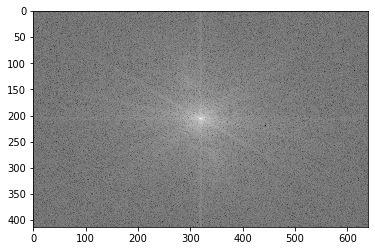

In [81]:
plt.imshow(magnitud_espectro_rojo_2, cmap = 'gray')

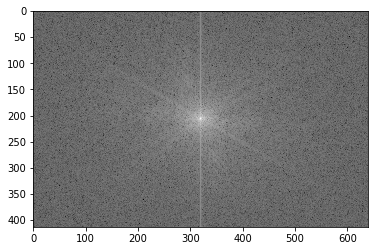

In [82]:
plt.imshow(magnitud_espectro_verde_2, cmap = 'gray')

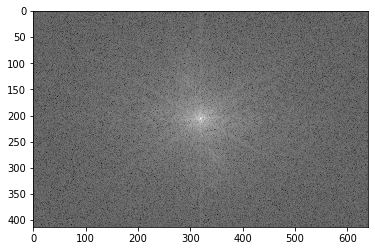

In [83]:
plt.imshow(magnitud_espectro_azul_2, cmap = 'gray')

In [84]:
#Calcular las transformadas de fourier de cada canal para la imagen con ruido 3

nueva_imagen_3_vargas_rojo = sacar_imagen_canal(nueva_imagen_3_vargas, 0)
nueva_imagen_3_vargas_verde = sacar_imagen_canal(nueva_imagen_3_vargas, 1)
nueva_imagen_3_vargas_azul = sacar_imagen_canal(nueva_imagen_3_vargas, 2)

f_rojo_3 = np.fft.fft2(nueva_imagen_3_vargas_rojo)
f_verde_3 = np.fft.fft2(nueva_imagen_3_vargas_verde)
f_azul_3 = np.fft.fft2(nueva_imagen_3_vargas_azul)

fshift_rojo_3 = np.fft.fftshift(f_rojo_3)
fshift_verde_3 = np.fft.fftshift(f_verde_3)
fshift_azul_3 = np.fft.fftshift(f_azul_3)

magnitud_espectro_rojo_3 = 20*np.log(np.abs(fshift_rojo_3))
magnitud_espectro_verde_3 = 20*np.log(np.abs(fshift_verde_3))
magnitud_espectro_azul_3 = 20*np.log(np.abs(fshift_azul_3))

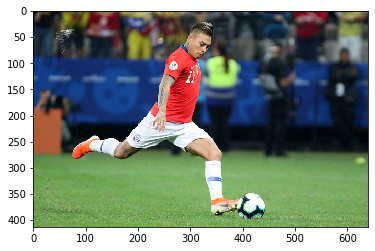

In [85]:
plt.imshow(nueva_imagen_3_vargas)

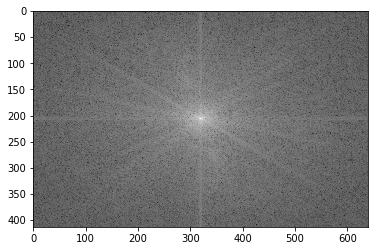

In [86]:
plt.imshow(magnitud_espectro_rojo_3, cmap = 'gray')

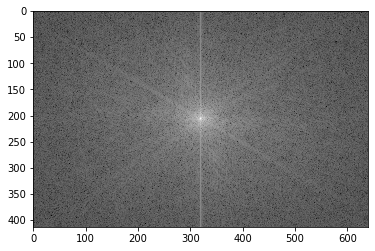

In [87]:
plt.imshow(magnitud_espectro_verde_3, cmap = 'gray')

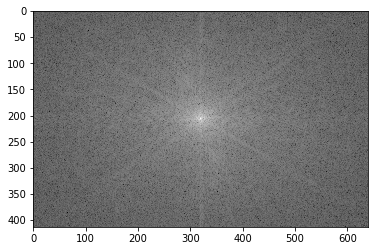

In [88]:
plt.imshow(magnitud_espectro_azul_3, cmap = 'gray')

$ Eliminar \ ruido \ y \ contrastar \ más \ los \ bordes $

Ahora para esta imagen aplicaremos de inmediato el filtro para eliminar ruido y contrastar bordes.Aquí se utiliza un filtro pasa alto y un filtro pasa bajo simultaneamente con estructura de circulo. Este tipo de filtros también se les conoce como "filtro pasa banda". 

In [89]:
radio_2 = 150
radio_1 = 20
fshift_rojo_1_modificado = aplicar_filtro_pasa_bajo_alto(fshift_rojo_1, radio_1, radio_2)
fshift_verde_1_modificado = aplicar_filtro_pasa_bajo_alto(fshift_verde_1, radio_1, radio_2)
fshift_azul_1_modificado = aplicar_filtro_pasa_bajo_alto(fshift_azul_1, radio_1, radio_2)

magnitud_espectro_rojo_1_modificado = 20*np.log(np.abs(fshift_rojo_1_modificado))
magnitud_espectro_verde_1_modificado = 20*np.log(np.abs(fshift_verde_1_modificado))
magnitud_espectro_azul_1_modificado = 20*np.log(np.abs(fshift_azul_1_modificado))

In [90]:
f_ishift_rojo_1_modificado = np.fft.ifftshift(fshift_rojo_1_modificado)
img_back_rojo_1_modificado = np.fft.ifft2(f_ishift_rojo_1_modificado)
img_back_rojo_1_modificado = np.uint8(np.abs(img_back_rojo_1_modificado))

f_ishift_verde_1_modificado = np.fft.ifftshift(fshift_verde_1_modificado)
img_back_verde_1_modificado = np.fft.ifft2(f_ishift_verde_1_modificado)
img_back_verde_1_modificado = np.uint8(np.abs(img_back_verde_1_modificado))

f_ishift_azul_1_modificado = np.fft.ifftshift(fshift_azul_1_modificado)
img_back_azul_1_modificado = np.fft.ifft2(f_ishift_azul_1_modificado)
img_back_azul_1_modificado = np.uint8(np.abs(img_back_azul_1_modificado))

imagen_total_1_modificado = union_imagen(img_back_rojo_1_modificado, img_back_verde_1_modificado, img_back_azul_1_modificado)

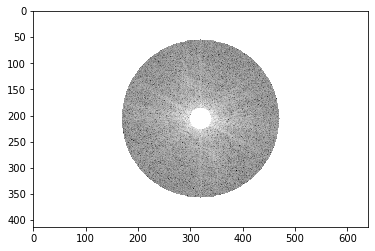

In [91]:
plt.imshow(magnitud_espectro_rojo_1_modificado, cmap = 'gray')

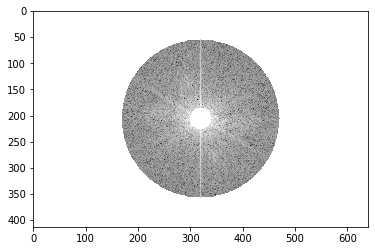

In [92]:
plt.imshow(magnitud_espectro_verde_1_modificado, cmap = 'gray')

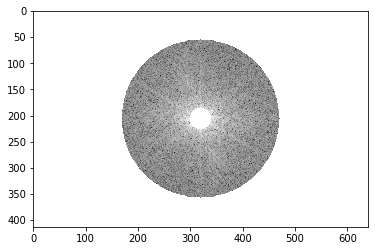

In [93]:
plt.imshow(magnitud_espectro_azul_1_modificado, cmap = 'gray')

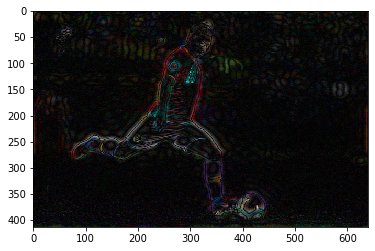

In [94]:
plt.imshow(imagen_total_1_modificado)

In [95]:
radio_2 = 150
radio_1 = 20
fshift_rojo_2_modificado = aplicar_filtro_pasa_bajo_alto(fshift_rojo_2, radio_1, radio_2)
fshift_verde_2_modificado = aplicar_filtro_pasa_bajo_alto(fshift_verde_2, radio_1, radio_2)
fshift_azul_2_modificado = aplicar_filtro_pasa_bajo_alto(fshift_azul_2, radio_1, radio_2)

magnitud_espectro_rojo_2_modificado = 20*np.log(np.abs(fshift_rojo_2_modificado))
magnitud_espectro_verde_2_modificado = 20*np.log(np.abs(fshift_verde_2_modificado))
magnitud_espectro_azul_2_modificado = 20*np.log(np.abs(fshift_azul_2_modificado))

In [96]:
f_ishift_rojo_2_modificado = np.fft.ifftshift(fshift_rojo_2_modificado)
img_back_rojo_2_modificado = np.fft.ifft2(f_ishift_rojo_2_modificado)
img_back_rojo_2_modificado = np.uint8(np.abs(img_back_rojo_2_modificado))

f_ishift_verde_2_modificado = np.fft.ifftshift(fshift_verde_2_modificado)
img_back_verde_2_modificado = np.fft.ifft2(f_ishift_verde_2_modificado)
img_back_verde_2_modificado = np.uint8(np.abs(img_back_verde_2_modificado))

f_ishift_azul_2_modificado = np.fft.ifftshift(fshift_azul_2_modificado)
img_back_azul_2_modificado = np.fft.ifft2(f_ishift_azul_2_modificado)
img_back_azul_2_modificado = np.uint8(np.abs(img_back_azul_2_modificado))

imagen_total_2_modificado = union_imagen(img_back_rojo_2_modificado, img_back_verde_2_modificado, img_back_azul_2_modificado)

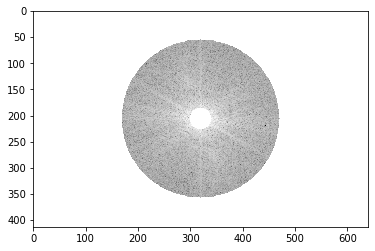

In [97]:
plt.imshow(magnitud_espectro_rojo_2_modificado, cmap = 'gray')

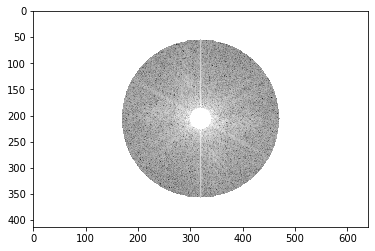

In [98]:
plt.imshow(magnitud_espectro_verde_2_modificado, cmap = 'gray')

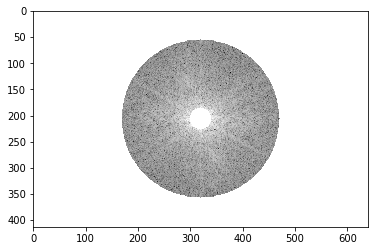

In [99]:
plt.imshow(magnitud_espectro_azul_2_modificado, cmap = 'gray')

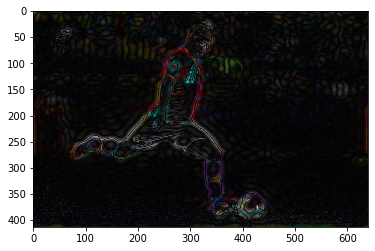

In [100]:
plt.imshow(imagen_total_2_modificado)

In [101]:
radio_2 = 150
radio_1 = 20
fshift_rojo_3_modificado = aplicar_filtro_pasa_bajo_alto(fshift_rojo_3, radio_1, radio_2)
fshift_verde_3_modificado = aplicar_filtro_pasa_bajo_alto(fshift_verde_3, radio_1, radio_2)
fshift_azul_3_modificado = aplicar_filtro_pasa_bajo_alto(fshift_azul_3, radio_1, radio_2)

magnitud_espectro_rojo_3_modificado = 20*np.log(np.abs(fshift_rojo_3_modificado))
magnitud_espectro_verde_3_modificado = 20*np.log(np.abs(fshift_verde_3_modificado))
magnitud_espectro_azul_3_modificado = 20*np.log(np.abs(fshift_azul_3_modificado))

In [102]:
f_ishift_rojo_3_modificado = np.fft.ifftshift(fshift_rojo_3_modificado)
img_back_rojo_3_modificado = np.fft.ifft2(f_ishift_rojo_3_modificado)
img_back_rojo_3_modificado = np.uint8(np.abs(img_back_rojo_3_modificado))

f_ishift_verde_3_modificado = np.fft.ifftshift(fshift_verde_3_modificado)
img_back_verde_3_modificado = np.fft.ifft2(f_ishift_verde_3_modificado)
img_back_verde_3_modificado = np.uint8(np.abs(img_back_verde_3_modificado))

f_ishift_azul_3_modificado = np.fft.ifftshift(fshift_azul_3_modificado)
img_back_azul_3_modificado = np.fft.ifft2(f_ishift_azul_3_modificado)
img_back_azul_3_modificado = np.uint8(np.abs(img_back_azul_3_modificado))

imagen_total_3_modificado = union_imagen(img_back_rojo_3_modificado, img_back_verde_3_modificado, img_back_azul_3_modificado)

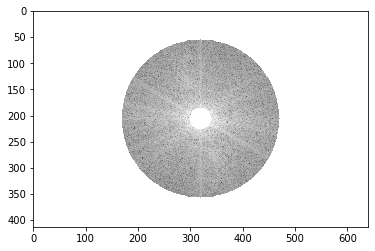

In [103]:
plt.imshow(magnitud_espectro_rojo_3_modificado, cmap = 'gray')

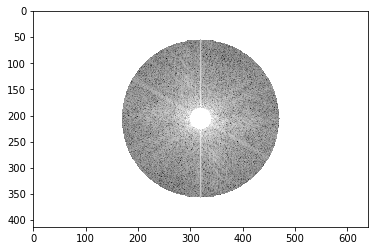

In [104]:
plt.imshow(magnitud_espectro_verde_3_modificado, cmap = 'gray')

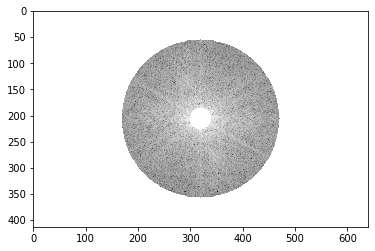

In [105]:
plt.imshow(magnitud_espectro_azul_3_modificado, cmap = 'gray')

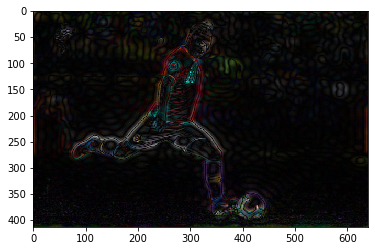

In [106]:
plt.imshow(imagen_total_3_modificado)